This tutorial is about
- Define fermion systems
- Use determinant to learn fermion ground states

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import quantax as qtx

lattice = qtx.sites.Square(4, Nparticle=(4, 4), is_fermion=True)  # fermion lattice
N = lattice.N

In [2]:
from quantax.symmetry import SpinInverse, C4v, Trans2D

# Hubbard model
H = qtx.operator.Hubbard(U=4)

# determinant with 8 electrons
model = qtx.model.Determinant()

state = qtx.state.Variational(
    model,
    max_parallel=32768, # maximum forward batch on each machine
)

# new samples proposed by electron hopping
sampler = qtx.sampler.ParticleHop(state, 1000)
tdvp = qtx.optimizer.TDVP(state, H)

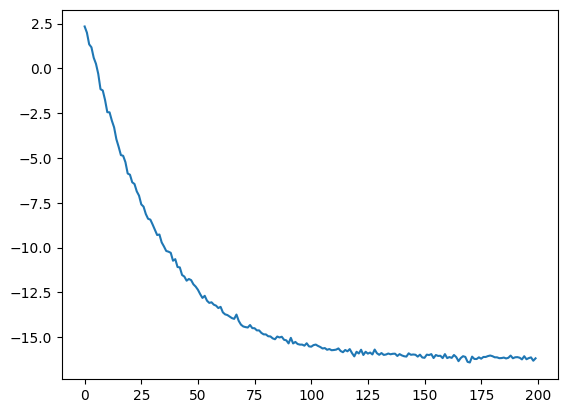

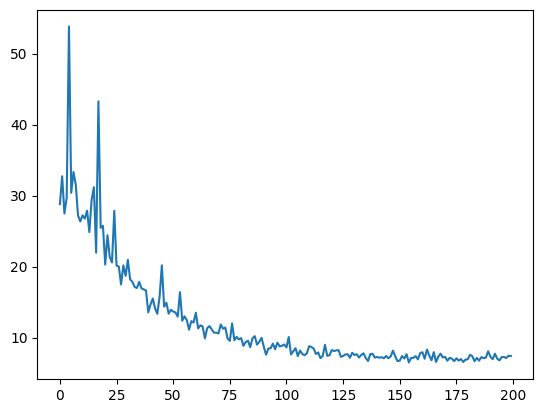

In [3]:
energy_data = qtx.utils.DataTracer()
VarE_data = qtx.utils.DataTracer()

for i in range(200):
    samples = sampler.sweep()
    step = tdvp.get_step(samples)
    state.update(step * 0.01)
    energy_data.append(tdvp.energy)
    VarE_data.append(tdvp.VarE)

energy_data.plot()
plt.show()
VarE_data.plot()
plt.show()

In [4]:
# symmetrize the trained NQS
# The ground state sector is in the B1 representation
symm = Trans2D() + SpinInverse() + C4v("B1")

symm_state = qtx.state.Variational(
    state.model,
    symm=symm,
    max_parallel=32768,
)

sampler = qtx.sampler.NeighborExchange(symm_state, 1000)
tdvp = qtx.optimizer.TDVP(symm_state, H)

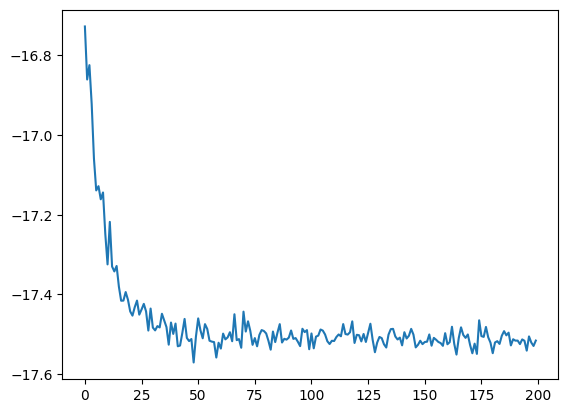

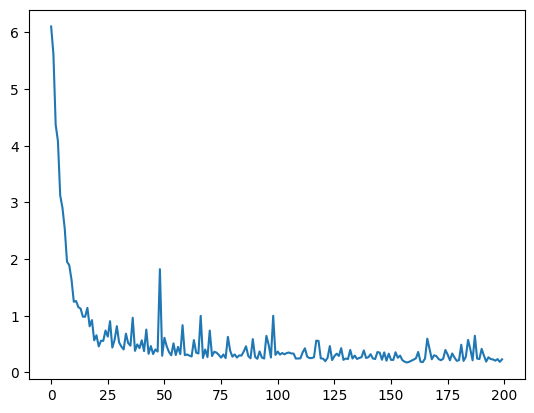

In [5]:
energy_data = qtx.utils.DataTracer()
VarE_data = qtx.utils.DataTracer()

for i in range(200):
    samples = sampler.sweep()
    step = tdvp.get_step(samples)
    symm_state.update(step * 0.01)
    energy_data.append(tdvp.energy)
    VarE_data.append(tdvp.VarE)

energy_data.plot()
plt.show()
VarE_data.plot()
plt.show()

In [6]:
# check result by ED
E, wf = H.diagonalize(symm)
print(E[0])

/home/chenao/quantax_env/lib/python3.12/site-packages/quantax/symmetry/symmetry.py:261: GeneralBasisWarning: using non-commuting symmetries can lead to unwanted behaviour of general basis, make sure that quantum numbers are invariant under non-commuting symmetries!
  self.basis.make()


-17.5348977966412
